Import Library

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib

Load Dataset

In [86]:
df = pd.read_csv('/content/ObesityDataSet.csv')

EDA

In [87]:
print("Data Info:")
print(df.info())

print("\n 5 Data Pertama:")
print(df.head())

print("\n Missing Values:")
print(df.isnull().sum())

print("\n Data Duplikat:", df.duplicated().sum())

print("\n Unique Values:")
print(df.nunique())

print("\n Distribusi Target:")
print(df["NObeyesdad"].value_counts())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                             2103 

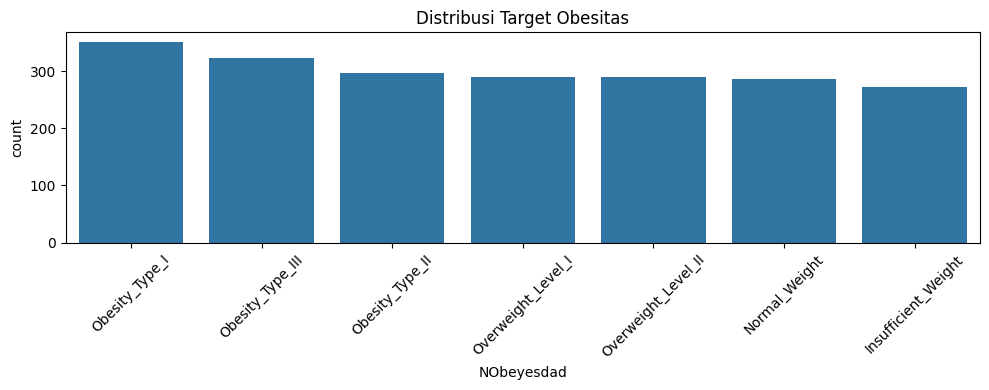

In [88]:
# Visualisasi distribusi target
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="NObeyesdad", order=df["NObeyesdad"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Target Obesitas")
plt.tight_layout()
plt.show()

In [89]:
# Daftar kolom yang seharusnya numerik
numerik_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'TUE', 'FAF']

# Ubah jadi numerik
for col in numerik_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Cek ulang tipe data
print(df.dtypes)

Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


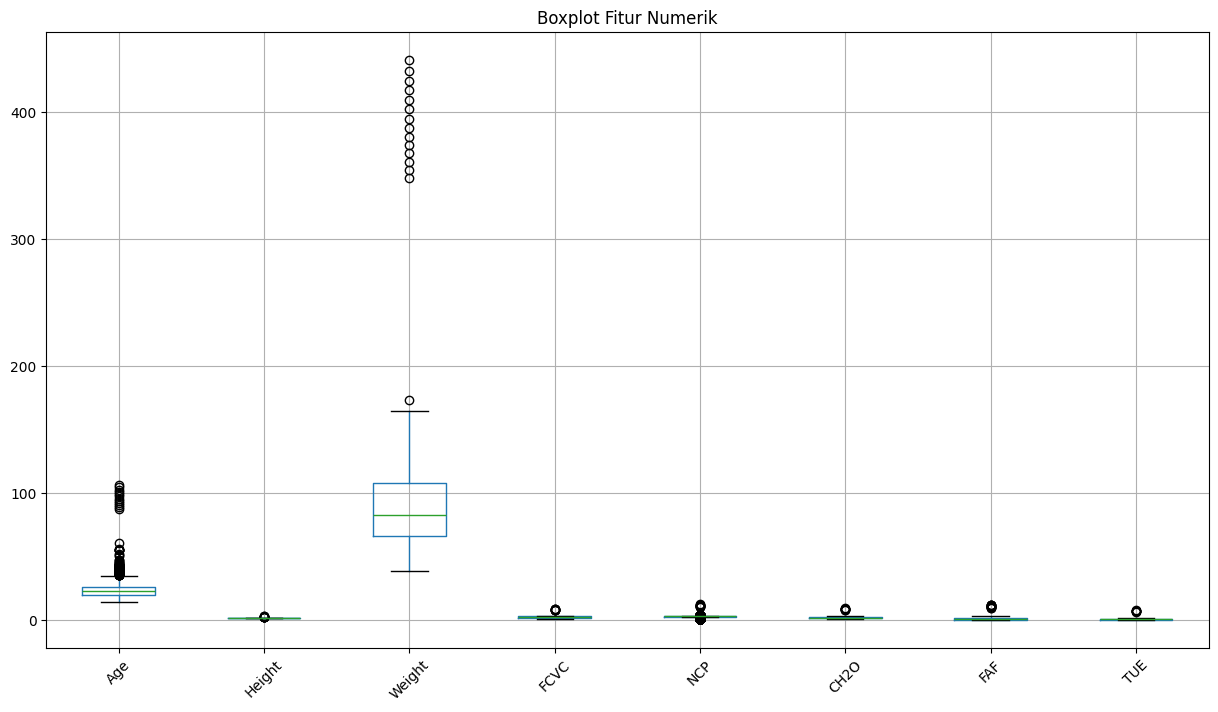

In [90]:
# Boxplot untuk deteksi outlier numerik
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 8))
df[numeric_cols].boxplot()
plt.title("Boxplot Fitur Numerik")
plt.xticks(rotation=45)
plt.show()

Data Processing

In [91]:
# Encode label target dari string
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['NObeyesdad'])  # hanya fit-transform ke y

# Simpan label string asli di encoder
# Jangan ubah df['NObeyesdad'] agar encoder tetap valid

# Pisahkan fitur dari label
df_clean = df.drop(columns=['NObeyesdad']).copy()

# Imputasi numerik (mean)
mean_cols = ['Age', 'Height', 'Weight', 'NCP', 'FAF', 'CH2O', 'TUE']
mean_imputer = SimpleImputer(strategy='mean')
df_clean[mean_cols] = mean_imputer.fit_transform(df_clean[mean_cols])

# Imputasi median
median_cols = ['FCVC']
median_imputer = SimpleImputer(strategy='median')
df_clean[median_cols] = median_imputer.fit_transform(df_clean[median_cols])

# Imputasi kategorikal (modus)
mode_cols = ['Gender', 'CALC', 'CAEC', 'MTRANS', 'FAVC', 'SCC', 'SMOKE', 'family_history_with_overweight']
mode_imputer = SimpleImputer(strategy='most_frequent')
df_clean[mode_cols] = mode_imputer.fit_transform(df_clean[mode_cols])

# One-hot encoding fitur
X_encoded = pd.get_dummies(df_clean, drop_first=True)
X = X_encoded


In [92]:
print("Isi label_encoder.classes_:", label_encoder.classes_)


Isi label_encoder.classes_: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [93]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

Modeling & Evaluasi

In [94]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [95]:
print("📈 Evaluasi Model Awal:\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"📌 {name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, average="weighted", zero_division=0))
    print("F1 Score :", f1_score(y_test, y_pred, average="weighted", zero_division=0))
    print("="*60)

📈 Evaluasi Model Awal:

📌 Random Forest
Accuracy : 0.926829268292683
Precision: 0.9289319183218514
Recall   : 0.926829268292683
F1 Score : 0.9270818463302481
📌 Logistic Regression
Accuracy : 0.7459349593495935
Precision: 0.737157694341787
Recall   : 0.7459349593495935
F1 Score : 0.7344862161343895
📌 SVM
Accuracy : 0.8109756097560976
Precision: 0.8131687898797084
Recall   : 0.8109756097560976
F1 Score : 0.810287204205138


Hyperparameter Tuning (Random Forest)

In [96]:
param_grid = {
    "n_estimators": [100, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

# Grid SearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='f1_weighted',
    verbose=1
)

grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print("✅ Best Params RF:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Params RF: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}


In [97]:
# Pastikan label encoder sudah di-fit pada df['NObeyesdad'] (bentuk string aslinya)

# Evaluasi
target_names = label_encoder.classes_

print("\n📌 Evaluasi Model Terbaik (Random Forest after tuning)")
print(classification_report(y_test, y_pred_best, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))



📌 Evaluasi Model Terbaik (Random Forest after tuning)
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.94      0.95        68
      Normal_Weight       0.88      0.91      0.89        74
     Obesity_Type_I       0.90      0.96      0.93        68
    Obesity_Type_II       0.97      0.99      0.98        70
   Obesity_Type_III       0.99      1.00      0.99        74
 Overweight_Level_I       0.92      0.91      0.92        66
Overweight_Level_II       0.98      0.90      0.94        72

           accuracy                           0.94       492
          macro avg       0.94      0.94      0.94       492
       weighted avg       0.94      0.94      0.94       492

Confusion Matrix:
 [[64  3  0  0  0  1  0]
 [ 3 67  1  0  0  3  0]
 [ 0  1 65  1  0  1  0]
 [ 0  0  1 69  0  0  0]
 [ 0  0  0  0 74  0  0]
 [ 0  4  0  0  1 60  1]
 [ 0  1  5  1  0  0 65]]


Deployment

In [98]:
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(X_encoded.columns.tolist(), "feature_columns.pkl")

print("✅ Model, scaler, encoder, dan fitur berhasil disimpan!")

✅ Model, scaler, encoder, dan fitur berhasil disimpan!
